In [ ]:
# For use of auto arima into the model
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.4 MB/s eta 0:00:00


In [ ]:
# Setup notebook
import pandas as pd #data frame operations
import matplotlib.pyplot as plt # plotting
import numpy as np  # numercial operations
import seaborn as sns   #plotting
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess #fourier series
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import itertools
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima #auto arima model

import warnings
warnings.filterwarnings("ignore")

#Configure plot styles

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/SCM256 Supply Chain/finaldata.csv"
data = pd.read_csv(path,parse_dates=['usage_date'], date_parser=lambda x: datetime.strptime(x, '%d-%m-%Y').date())
# Dataset is now stored in a Pandas Dataframe

In [ ]:
#creating small dataset only with necessary columns of usage date, region zone and sold qty
small_data = data[['usage_date', 'Region_Zone', 'Sold QTY']]
#Sortting based on Region Zone, this will help us into making smaller data frame
small_data.sort_values(by='Region_Zone',ignore_index=True)

,usage_date,Region_Zone,Sold QTY
0,2019-05-16,Alpha-a,0
1,2021-01-24,Alpha-a,0
2,2021-01-25,Alpha-a,0
3,2019-09-29,Alpha-a,0
4,2021-01-26,Alpha-a,0
...,...,...,...
12995,2021-01-17,Gamma-c,8080
12996,2021-01-16,Gamma-c,8080
12997,2021-01-15,Gamma-c,8080
12998,2021-01-27,Gamma-c,8080


In [ ]:
#groupding by usage date and region zone. 
final = small_data.groupby(['usage_date', 'Region_Zone'])['Sold QTY'].sum().unstack()
draft = final.copy()
#Calculating the net sum across dates and product models
draft['net'] = draft.sum(axis=1)

In [ ]:
draft.reset_index(inplace=True)

In [ ]:
draft

Region_Zone,usage_date,Alpha-a,Alpha-b,Beta-a,Beta-b,Beta-c,Delta-a,Delta-b,Delta-c,Epsilon-b,Epsilon-d,Gamma-a,Gamma-b,Gamma-c,net
0,2019-05-16,0,0,0,400,1024,0,120,680,2168,1376,16464,13400,2880,38512
1,2019-05-17,0,0,0,560,1024,0,120,680,2008,1376,14388,12250,2560,34966
2,2019-05-18,0,0,0,320,1024,0,120,680,1752,1359,15392,12880,2400,35927
3,2019-05-19,0,0,0,320,1024,0,120,680,1912,1416,11731,8634,2383,28220
4,2019-05-20,0,0,0,400,1024,0,120,680,2128,1552,15040,12741,2640,36325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-02-04,7624,6672,1564,9865,6144,9070,12237,7418,11304,7175,63542,51273,15157,209045
996,2022-02-05,7624,6672,1525,9867,6024,9119,12157,7475,11053,7088,61816,50624,14065,205109
997,2022-02-06,8104,7472,1484,9840,6064,9150,12157,7495,11088,7073,61511,50441,14048,205927
998,2022-02-07,7144,6672,1522,10176,6048,9197,12232,7552,11209,7288,62662,50851,13984,206537


In [ ]:
# Predictions using Fourier and Lags. 

# For prediction making lags
def make_lags(ts, lags, lag_time=1, name='y'):
    return pd.concat(
        {f'{name}_lag_{i}': ts.shift(i)
         for i in range(lag_time, lags + lag_time)},
        axis=1)

# create dataframe with n='leads' leads with 'lead_time' and prefixed by 'name'
def make_leads(ts, leads, lead_time=1, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(lead_time, leads+lead_time))},
        axis=1)

#Making fourier transofrms 
def fourier(df):
  #fourier transformation
  #print("FOURIER ANALYSIS")
  y =  df.loc[:, df.columns[0]].squeeze()
  fourier = CalendarFourier(freq='D', order=7) # Unit of frequncey is set to replicate Daily data with weekly seasonality
  dp = DeterministicProcess(
      constant=True,
      index=y.index,
      order=1,
      seasonal=True,
      drop=True,
      additional_terms=[fourier],
      )
  return dp.in_sample()

In [ ]:
# Function used for forecasting. 
# The input is a data frame with date and sold qty for each region zone 

def forecasting(df):
  
  print(df.columns[1]) #Printing the product / region one name

  df['usage_date'] = pd.to_datetime(df['usage_date'])
  df= df.set_index('usage_date')
  df= df[df[df.columns[0]] != 0]

  #print(df)
  #Defining y
  y =  df.loc[:, df.columns[0]].squeeze()
  #print("**************y*******************")
  #print(y)

  #Get foureir data table
  X_time = fourier(df)
  #print("**************x tiem fourier*******************")
  #print(X_time)
  
  #Get Seasonal data using linear regression on fourier terms
  model1 = LinearRegression(fit_intercept=False)
  model1.fit(X_time, y)

  # Finding deseadonal data by removing the linear regression of fourier terms
  y_deseason = y - model1.predict(X_time)
  y_deseason.name = 'Demand_unseasoned'
  
  # Get lags data
  X_lags = make_lags(y_deseason, lags=1, name='y_1_deseason') #lag data came from the ACF,PCF plots above
  
  # Combing lags, deseaasonal data into one dataframe
  M = pd.concat([y_deseason,X_lags],axis=1).dropna()


  # Getting X and Y ready
  X = pd.concat([X_time, X_lags], axis=1).dropna()
  y, X = y.align(X, join='inner')

  # Splitting X and Y into training and testing data (20% is testing)
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

  #print(X_train)
  #print(X_valid)

  # Create linear regression of X train and Y train
  model2 = LinearRegression(fit_intercept=False).fit(X_train, y_train)

  # Predicting on the data
  y_fit = pd.Series(model2.predict(X_train), index=X_train.index).clip(0.0) #.clip(0.0) removes negative values
  y_pred = pd.Series(model2.predict(X_valid), index=X_valid.index).clip(0.0) #.clip(0.0) removes negative values


  last_date = X_valid.index[-1]
  last_trend = X_valid.iloc[-1]['trend']
  print(last_date)

  forecast_index = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365, freq='D')
  new_df = pd.DataFrame(index=forecast_index, columns=['data'])
  new_fourier = fourier(new_df)
  
  new_fourier.loc[new_fourier.index[0], 'trend'] = last_trend
  #print(len(new_fourier))
  new_fourier.iloc[1:, new_fourier.columns.get_loc('trend')] = range(int(last_trend) + 1, int(last_trend) + 1 + len(new_fourier) - 1)

  new_fourier['y_1_deseason_lag_1']=0
  
  #print("******",new_fourier)

  y_pred_new = pd.Series(model2.predict(new_fourier), index=new_fourier.index).clip(0.0) #.clip(0.0) removes negative values
  #print(y_pred_new)

  '''
  new_lags = make_lags(y_pred_new, lags=1, name='y_1_deseason')
  print(new_lags)

  new_fourier = new_fourier.drop(['y_1_deseason_lag_1'], axis=1)
  N = pd.concat([new_fourier,new_lags],axis=1).dropna()
  print(N)

  y_pred_new_wilags = pd.Series(model.predict(N), index=N.index).clip(0.0) #.clip(0.0) removes negative values
  print(y_pred_new_wilags)
  '''

  # Do MAPE and RMSE on the data and print it
  rmse_train = mean_squared_error(y_train, y_fit, squared=False) 
  rmse_valid = mean_squared_error(y_valid, y_pred, squared=False) 
  print(f'Training RMSE: {rmse_train:.5f}')
  print(f'Validation RMSE: {rmse_valid:.5f}')

  mape_train = mean_absolute_percentage_error(y_train, y_fit)
  mape_valid = mean_absolute_percentage_error(y_valid, y_pred)
  print(f'Training MAPE: {mape_train:.5f}')
  print(f'Validation MAPE: {mape_valid:.5f}')

  #y =  df.loc[:, df.columns[0]].squeeze()
  #lag1 = pd.DataFrame(X['y_1_deseason_lag_1'])
  lag1 = X.loc[:,'y_1_deseason_lag_1'].squeeze()
  print(lag1)

  print("**************actual lags*******************")
  #lag1.columns = ['lag']
  #print(lag1)
  #print("**************lags fourier*******************")
  lag1_fourier = fourier(X)
  #print(lag1_fourier)
  #print("***************end******************")

  model3 = LinearRegression(fit_intercept=True)
  model3.fit(lag1_fourier, lag1)
  #print(new_fourier)
  print("***************new prediction fourier range******************")
  new_lag = new_fourier.drop('y_1_deseason_lag_1',axis=1)
  
  #print(new_lag)
  #print(new_lag.index)

  lag_new = pd.Series(model3.predict(new_lag), index=new_lag.index , name='y_1_deseason_lag_1')
  #print(lag_new)
  #lag_new.columns=['y_1_deseason_lag_1']
  print("***************lag new******************")
  #print(lag_new)


  N = pd.concat([new_lag,lag_new],axis=1).dropna()
  #print(N)

  y_pred_new_wi = pd.Series(model2.predict(N), index=N.index) #.clip(0.0) removes negative values
  #print(y_pred_new_wi)

  #Predicting using texp
  y_texp_model = ExponentialSmoothing(lag1,trend = 'add', seasonal ='add', seasonal_periods = 7 ).fit()
  print(y_texp_model)

  # Predict for test data
  n = 365 # length of n for prediction
  pred_sexp = y_texp_model.forecast(n)
  print(pred_sexp)

  
  #Predicting arima
  model4 = auto_arima(lag1, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=7, stepwise=True) # 7 is kept here for weekly seasonality
  model4.fit(lag1) 

  #Predictions
  pred = model4.predict()
  forecast = model4.predict(n_periods=365)
  forecast = pd.DataFrame(forecast,index = new_lag.index,columns=['y_1_deseason_lag_1'])
  print(forecast)
  N = pd.concat([new_lag,forecast],axis=1).dropna()
  print(N)
  y_pred_new_wi_arima = pd.Series(model2.predict(N), index=N.index) #.clip(0.0) removes negative values

  # plot train , test and the predictions
  ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
  ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
  ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
  ax = y_pred_new.plot(ax=ax, label="Forecast with 0 lags", color='C3')
  ax = y_pred_new_wi.plot(ax=ax, label="Forecast with Forecasted lags", color='C9')
  ax = y_pred_new_wi_arima.plot(ax=ax, label="Forecast with Forecasted lags arima", color='C9')
  ax = lag1.plot(ax=ax, label="Current Lags", color='C6')
  ax = lag_new.plot(ax=ax, label="Lag1 Forecast", color='C6')
  ax = pred_sexp.plot(ax=ax, label="Lag1 Forecast HW", color='C6')
  ax = forecast.plot(ax=ax, label="Lag1 Forecast Arima", color='C8')

  ax.legend();



Alpha-a
2022-02-08 00:00:00
Training RMSE: 706.82460
Validation RMSE: 1500.26813
Training MAPE: 0.65505
Validation MAPE: 0.16694
usage_date
2021-06-04    1113.339301
2021-06-05     749.311523
2021-06-06     827.811523
2021-06-07    1235.700412
2021-06-08    1268.144857
                 ...     
2022-02-04   -2270.617079
2022-02-05   -2634.644857
2022-02-06   -2556.144857
2022-02-07   -1668.255968
2022-02-08   -2595.811523
Name: y_1_deseason_lag_1, Length: 250, dtype: float64
**************actual lags*******************
***************new prediction fourier range******************
***************lag new******************
2022-02-09   -2164.743307
2022-02-10   -2357.352808
2022-02-11   -2320.149585
2022-02-12   -2171.711308
2022-02-13   -2239.030017
                 ...     
2023-02-04   -1881.513552
2023-02-05   -1948.832262
2023-02-06   -2101.579177
2023-02-07   -2036.025652
2023-02-08   -1868.855399
Freq: D, Length: 365, dtype: float64
Performing stepwise search to minimize aic
 ARIMA

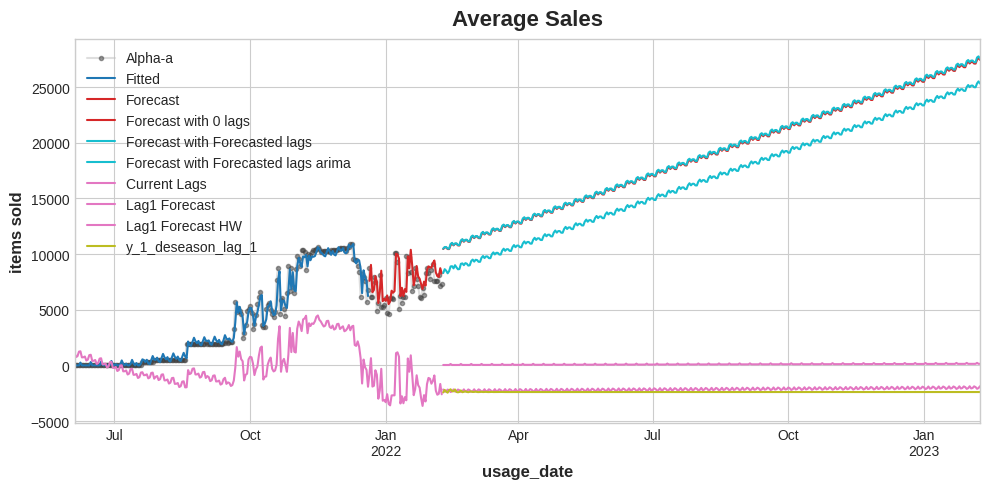

Alpha-b
2022-02-08 00:00:00
Training RMSE: 897.51682
Validation RMSE: 1400.11908
Training MAPE: 0.20473
Validation MAPE: 0.14653
usage_date
2021-07-29   -1171.992787
2021-07-30   -1095.492787
2021-07-31   -1424.671358
2021-08-01   -1410.492787
2021-08-02    -902.492787
                 ...     
2022-02-04   -2624.221499
2022-02-05   -3113.400070
2022-02-06   -3099.221499
2022-02-07   -1791.221499
2022-02-08   -2640.150070
Name: y_1_deseason_lag_1, Length: 195, dtype: float64
**************actual lags*******************
***************new prediction fourier range******************
***************lag new******************
2022-02-09    -2603.148739
2022-02-10    -2764.914085
2022-02-11    -2627.159333
2022-02-12    -2568.742542
2022-02-13    -2650.056550
                  ...     
2023-02-04   -14925.661024
2023-02-05   -15006.975033
2023-02-06   -15068.437478
2023-02-07   -15101.104650
2023-02-08   -15202.359741
Freq: D, Length: 365, dtype: float64
Performing stepwise search to minimize

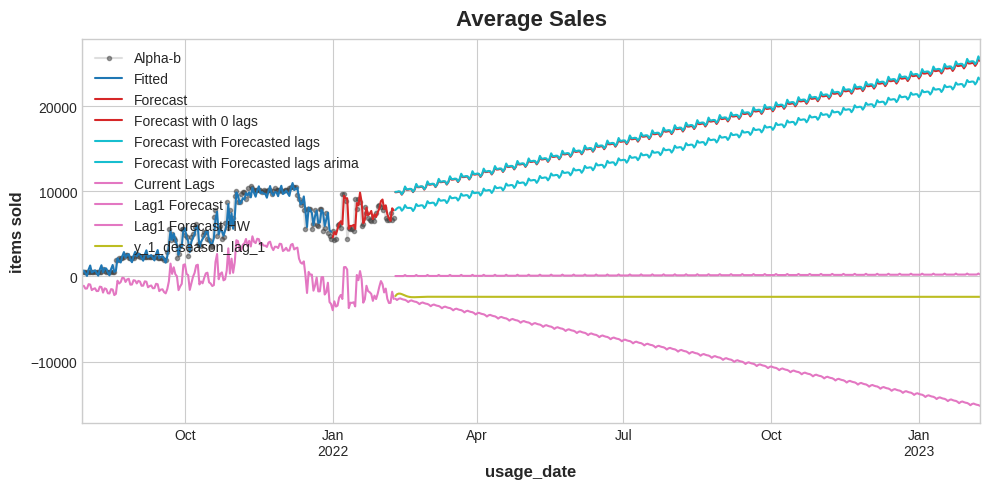

Beta-a
2022-02-08 00:00:00
Training RMSE: 71.89678
Validation RMSE: 68.35904
Training MAPE: 0.07317
Validation MAPE: 0.03949
usage_date
2021-09-22   -149.743347
2021-09-23   -206.572847
2021-09-24   -206.722847
2021-09-25   -215.572847
2021-09-26   -185.172847
                 ...    
2022-02-04   -201.077153
2022-02-05   -207.927153
2022-02-06   -216.527153
2022-02-07   -242.777153
2022-02-08   -225.177153
Name: y_1_deseason_lag_1, Length: 140, dtype: float64
**************actual lags*******************
***************new prediction fourier range******************
***************lag new******************
2022-02-09    -238.064638
2022-02-10    -229.235655
2022-02-11    -233.843463
2022-02-12    -237.501096
2022-02-13    -241.135964
                 ...     
2023-02-04   -2626.682504
2023-02-05   -2630.317373
2023-02-06   -2647.416652
2023-02-07   -2666.911953
2023-02-08   -2674.092741
Freq: D, Length: 365, dtype: float64
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[

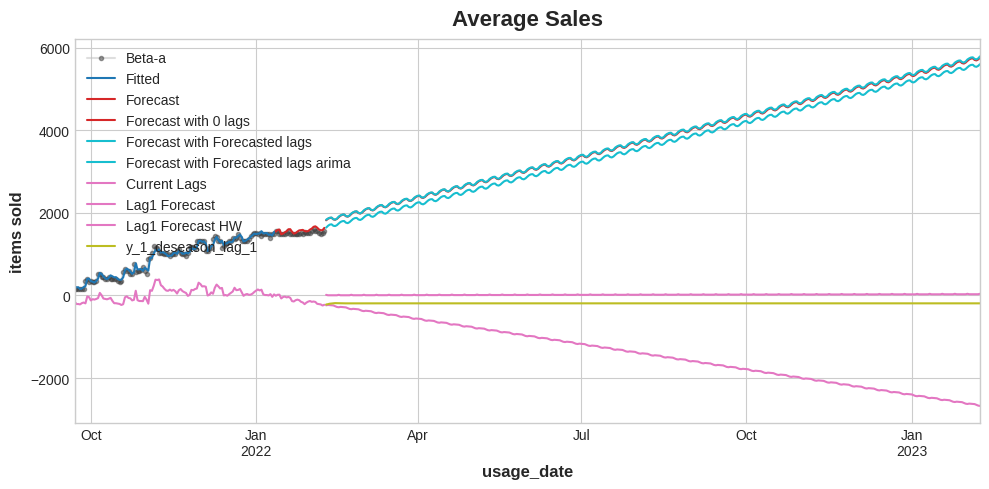

Beta-b
2022-02-08 00:00:00
Training RMSE: 237.34690
Validation RMSE: 209.30260
Training MAPE: 0.05713
Validation MAPE: 0.01823
usage_date
2019-05-17     847.486379
2019-05-18    1017.731135
2019-05-19     802.220645
2019-05-20     782.717149
2019-05-21     791.514351
                 ...     
2022-02-04      99.142991
2022-02-05      30.387747
2022-02-06      56.877257
2022-02-07      10.373761
2022-02-08     275.170963
Name: y_1_deseason_lag_1, Length: 999, dtype: float64
**************actual lags*******************
***************new prediction fourier range******************
***************lag new******************
2022-02-09    181.187551
2022-02-10    185.153314
2022-02-11    162.174942
2022-02-12    161.831739
2022-02-13    158.397040
                 ...    
2023-02-04     56.175161
2023-02-05     52.740462
2023-02-06     99.749169
2023-02-07     87.590660
2023-02-08     73.459276
Freq: D, Length: 365, dtype: float64
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1

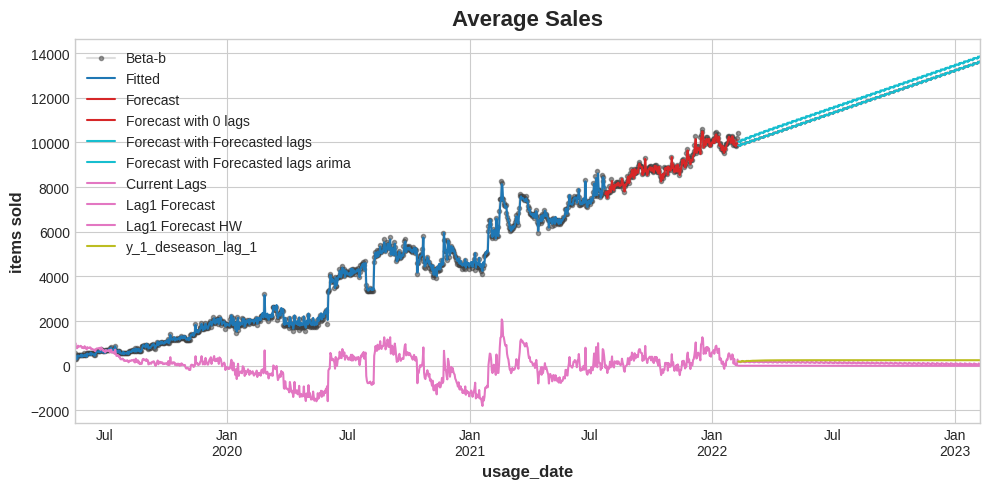

Beta-c
2022-02-08 00:00:00
Training RMSE: 164.05251
Validation RMSE: 186.99484
Training MAPE: 0.03825
Validation MAPE: 0.02477
usage_date
2019-05-17    232.945058
2019-05-18    233.616387
2019-05-19    253.679324
2019-05-20    261.735268
2019-05-21    221.091911
                 ...    
2022-02-04   -939.042960
2022-02-05   -802.371631
2022-02-06   -902.308694
2022-02-07   -854.252750
2022-02-08   -910.896107
Name: y_1_deseason_lag_1, Length: 999, dtype: float64
**************actual lags*******************
***************new prediction fourier range******************
***************lag new******************
2022-02-09    -953.676276
2022-02-10    -976.222744
2022-02-11    -984.750290
2022-02-12    -984.612868
2022-02-13    -968.619405
                 ...     
2023-02-04   -5575.872303
2023-02-05   -5559.878839
2023-02-06   -5551.240688
2023-02-07   -5589.070218
2023-02-08   -5634.960405
Freq: D, Length: 365, dtype: float64
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1

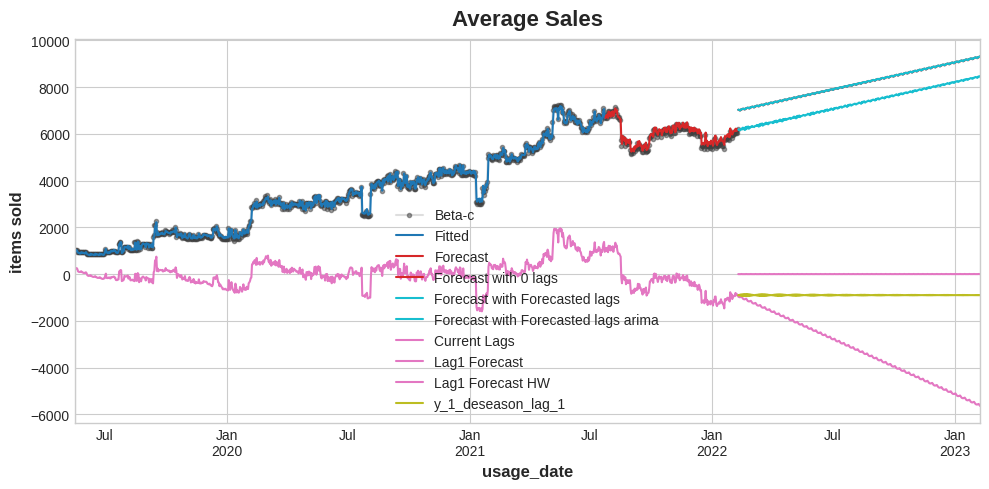

Delta-a
2022-02-08 00:00:00
Training RMSE: 226.80490
Validation RMSE: 236.40062
Training MAPE: 0.03754
Validation MAPE: 0.02213
usage_date
2020-02-12   -966.833833
2020-02-13   -405.618856
2020-02-14   -145.724625
2020-02-15    123.236913
2020-02-16   -113.388087
                 ...    
2022-02-04   -152.986913
2022-02-05     85.974625
2022-02-06     98.349625
2022-02-07    144.974625
2022-02-08    161.647702
Name: y_1_deseason_lag_1, Length: 728, dtype: float64
**************actual lags*******************
***************new prediction fourier range******************
***************lag new******************
2022-02-09     229.049360
2022-02-10     181.061685
2022-02-11     230.943627
2022-02-12     235.652472
2022-02-13     267.372887
                 ...     
2023-02-04    3897.841721
2023-02-05    3929.562136
2023-02-06    3894.175955
2023-02-07    3888.963228
2023-02-08    3963.046241
Freq: D, Length: 365, dtype: float64
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,

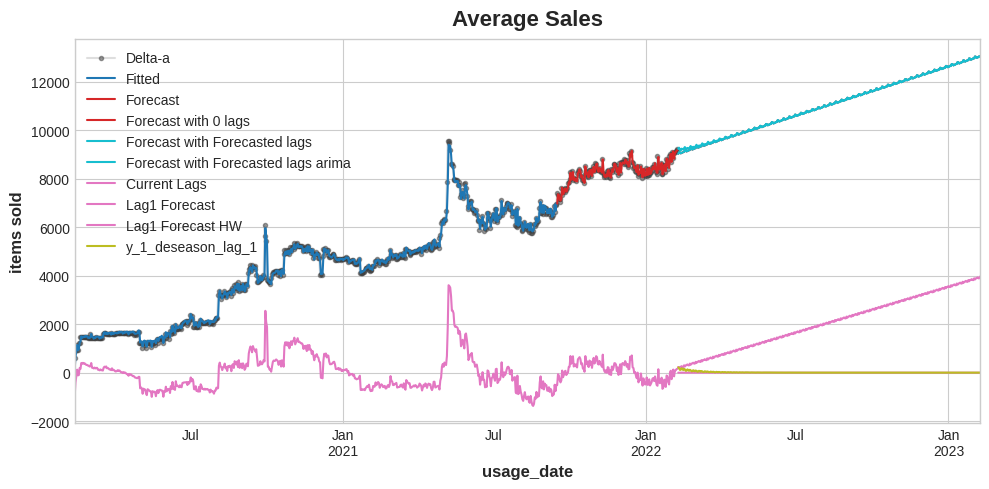

Delta-b
2022-02-08 00:00:00
Training RMSE: 281.91667
Validation RMSE: 229.72676
Training MAPE: 0.07009
Validation MAPE: 0.01563
usage_date
2019-05-17   -670.469450
2019-05-18   -621.420499
2019-05-19   -648.574345
2019-05-20   -636.651268
2019-05-21   -692.175744
                 ...    
2022-02-04   -340.481599
2022-02-05   -446.432648
2022-02-06   -553.586494
2022-02-07   -541.663417
2022-02-08   -522.187893
Name: y_1_deseason_lag_1, Length: 999, dtype: float64
**************actual lags*******************
***************new prediction fourier range******************
***************lag new******************
2022-02-09   -523.877150
2022-02-10   -523.711960
2022-02-11   -505.102612
2022-02-12   -512.165481
2022-02-13   -434.025196
                 ...    
2023-02-04   -312.410721
2023-02-05   -234.270437
2023-02-06   -272.932747
2023-02-07   -351.686066
2023-02-08   -320.205631
Freq: D, Length: 365, dtype: float64
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] inter

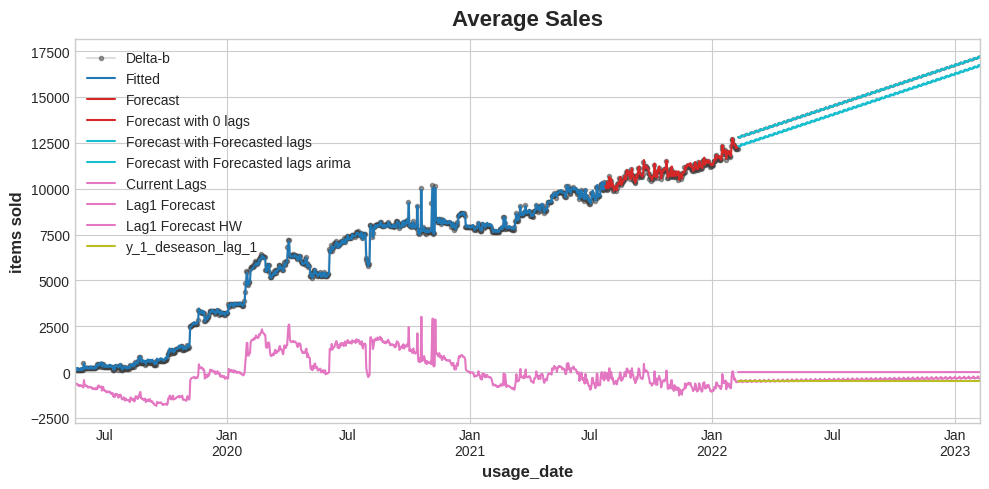

Delta-c
2022-02-08 00:00:00
Training RMSE: 479.57728
Validation RMSE: 272.81519
Training MAPE: 0.08336
Validation MAPE: 0.03723
usage_date
2019-05-17    -120.191107
2019-05-18    -111.135163
2019-05-19     -75.498800
2019-05-20     -45.289009
2019-05-21    -117.226072
                 ...     
2022-02-04    1638.219079
2022-02-05    1649.275023
2022-02-06    1741.911387
2022-02-07    1792.121177
2022-02-08    1777.184114
Name: y_1_deseason_lag_1, Length: 999, dtype: float64
**************actual lags*******************
***************new prediction fourier range******************
***************lag new******************
2022-02-09    1664.139409
2022-02-10    1736.316983
2022-02-11    1729.443656
2022-02-12    1705.180677
2022-02-13    1731.954761
                 ...     
2023-02-04    1941.234009
2023-02-05    1968.008093
2023-02-06    1973.226514
2023-02-07    1922.049588
2023-02-08    1904.821238
Freq: D, Length: 365, dtype: float64
Performing stepwise search to minimize aic
 ARIMA(

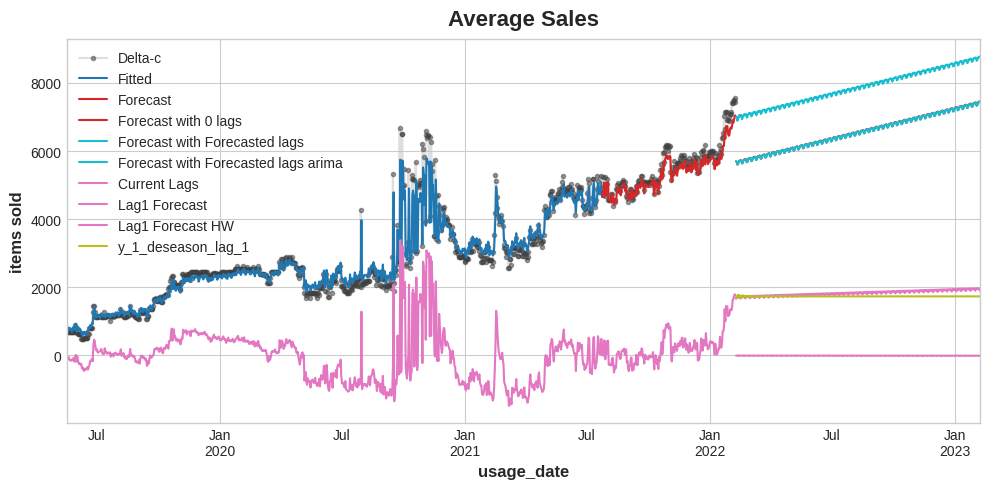

Epsilon-b
2022-02-08 00:00:00
Training RMSE: 1120.23458
Validation RMSE: 541.36831
Training MAPE: 0.10110
Validation MAPE: 0.04346
usage_date
2019-05-17     720.193049
2019-05-18     409.088154
2019-05-19     333.871370
2019-05-20     529.647594
2019-05-21     551.668573
                 ...     
2022-02-04    1620.848909
2022-02-05     978.744014
2022-02-06     908.527231
2022-02-07     979.303455
2022-02-08     906.324434
Name: y_1_deseason_lag_1, Length: 999, dtype: float64
**************actual lags*******************
***************new prediction fourier range******************
***************lag new******************
2022-02-09     981.314538
2022-02-10    1086.471608
2022-02-11    1124.250213
2022-02-12    1002.822414
2022-02-13    1208.989452
                 ...     
2023-02-04    8381.698470
2023-02-05    8587.865508
2023-02-06    8588.543177
2023-02-07    8499.582843
2023-02-08    8504.874438
Freq: D, Length: 365, dtype: float64
Performing stepwise search to minimize aic
 ARI

In [ ]:
for i in range( 1 , len ( draft.columns )   ): # Use 1 to len ( draft.columns ) to get all region zones data or use 11,12 (AS example) to get specifc region zones
    
    plt.rcParams['figure.figsize'] = [10, 5]
    sub_df = draft.loc[:, ['usage_date', draft.columns[i]]]
    forecasting(sub_df)
    plt.show()